# 抓取行政边界

### (1) Python库安装
  * pip安装： pip install geopandas
  * conda安装： conda install geopandas
  * 数据包安装： 安装包环境下，按“Shift”右键选择“在此处打开Powershells窗口”；输入 python setup.py install
  
### (2) 数据来源：高德API
  * **高德行政区划查询**：https://lbs.amap.com/api/webservice/guide/api/district
  * **输入参数说明**：
    * keywords = 上海  
       * 规则：只支持单个关键词语搜索关键词支持：行政区名称、citycode、adcode
       * 例如，在subdistrict=2，搜索省份（例如山东），能够显示市（例如济南），区（例如历下区）
    * adcode
    * subdistrict = 3  
       * 规则：设置显示下级行政区级数（行政区级别包括：国家、省/直辖市、市、区/县4个级别）
       * 可选值：0、1、2、3
       * 0：不返回下级行政区；
       * 1：返回下一级行政区；
       * 2：返回下两级行政区；
       * 3：返回下三级行政区；
    * extensions = all  
       * 此项控制行政区信息中返回行政区边界坐标点； 可选值：base、all;
       * base:不返回行政区边界坐标点；
       * all:只返回当前查询district的边界值，不返回子节点的边界值；
    * 返回polyline 行政区边界坐标点  
       * 当一个行政区范围，由完全分隔两块或者多块的地块组成，每块地的 polyline 坐标串以 | 分隔 。
    * page
       * 需要第几页数据
       * 最外层的districts最多会返回20个数据，若超过限制，请用page请求下一页数据。
       * 例如page=2；page=3。默认page=1
    * offset
       * 最外层返回数据个数, 默认20
  * **返回参数说明**：
    * status 返回结果状态值  值为0或1，0表示失败；1表示成功
    * count 返回结果数，0为没有数据
    * citycode 可能为空
    * polyline  多块区域由"|"分隔，点之间由";"分隔，经度纬度之间由","分隔
  * **key**: web服务， 上限2000
  * **高德行政区划**
    * 下载地址：https://lbs.amap.com/api/webservice/download

### (3) 其他问题
  * 环境变量设置：
    * 控制面板 -> 系统和安全 -> 系统 -> 高级系统设置 -> 环境变量 -> 用户/系统变量 -> path 添加
  * jupyter notebook 与 python 运行环境不同: 在python和jupyter中分别运行
    * import sys
    * sys.executable
    * 解决库无法导入问题：将python  D:\Python\Python37\Lib\site-packages 路径下.py包复制到 D:\Anaconda3\Lib 中


### (4) 参考文章
  * [获取行政区边界和利用GDAL生成shp文件](http://zhaoxuhui.top/blog/2017/07/20/%E8%8E%B7%E5%8F%96%E8%A1%8C%E6%94%BF%E5%8C%BA%E8%BE%B9%E7%95%8C%E5%92%8C%E5%88%A9%E7%94%A8GDAL%E7%94%9F%E6%88%90shp%E6%96%87%E4%BB%B6.html)
  * [使用GDAL创建Shape文件](https://www.cnblogs.com/ITGIS/p/3542601.html)

  * 修正原文中没有设置参考坐标系  
    * 添加wgs84坐标系：   https://blog.csdn.net/theonegis/article/details/80554993  
    * 添加投影：   http://geopandas.org/projections.html
    * 多个面合并成为一个文件（ogr资料）  https://pcjericks.github.io/py-gdalogr-cookbook/geometry.html#create-a-linestring
    * 增加code等信息
    * 其他资料
        * https://stackoverflow.com/questions/13198391/create-a-shape-file
        * https://blog.csdn.net/sinat_29675423/article/details/87434839
        * https://pcjericks.github.io/py-gdalogr-cookbook/geometry.html#create-a-multipoint

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import shapefile
import os
import requests
from bs4 import BeautifulSoup
import urllib
import json
import matplotlib.pyplot as plt
import TransformCoordinates as tc
%matplotlib inline

In [2]:
os.chdir(r'E:\2_Data\全国行政边界数据-高德API')

In [3]:
def get_district_polygon_from_amap(save_shp,key,adcode=None,keywords=None):
    # 访问链接，返回数据
    subdistrict = 3
    extensions = 'all'
    params = {'key': key,
             'keywords': keywords,
             'adcode': adcode,
             'subdistrict': 3,
             'extensions': 'all'}
    url = 'https://restapi.amap.com/v3/config/district?'
    r = requests.get(url,params=params)
    data = json.loads(r.text)

    # 分析数据
    if data['status'] == '0' or int(data['count']) < 1: 
        print('{} 没有返回数据，请假查输入参数！'.format(keywords))
    else:
        w = shapefile.Writer(save_shp)
        w.field('name','C',40)
        w.field('citycode','C',40)
        w.field('adcode','C',40)
        w.field('center','C',40)
        w.field('level','C',40)
        citycode = data['districts'][0]['citycode']
        adcode = data['districts'][0]['adcode']
        name = data['districts'][0]['name']
        polyline = data['districts'][0]['polyline']
        center = data['districts'][0]['center']
        level = data['districts'][0]['level']

        # 边界数据处理
        if '|' in polyline:
            multiPoly = []
            multipolylines = polyline.split('|')
            for polylines in multipolylines:
                singlePoly = []
                points = polylines.split(';')
                for point in points:
                    lon, lat = point.split(',')
                    coordinates_wgs84 = tc.TransformCoordinates().gcj02_wgs84(float(lon),float(lat))
                    singlePoly.append(coordinates_wgs84)
                multiPoly.append(singlePoly)
            w.poly(multiPoly)
        else:   # 只有一个边界
            singlePoly = []
            points = polyline.split(';')
            for point in points:
                lon, lat = point.split(',')
                coordinates_wgs84 = tc.TransformCoordinates().gcj02_wgs84(float(lon),float(lat))
                singlePoly.append(coordinates_wgs84)
            w.poly([singlePoly])
        w.record(name.encode('gbk'), citycode, adcode,center, level)  # 添加字段
        w.close()

In [ ]:
if __name__ == '__main__':   
    # 高德地图行政编号表
    amapcode = pd.read_excel('./AMap_adcode_citycode.xlsx', encoding='utf-8',dtype={'adcode':str,'citycode':str})
    
    # 爬取行政边界
    keys = 
    i = 0
    for adcode in amapcode.adcode.values:   
        if i / 1500 <= 1: key = keys[0]
        elif i / 1500 >=2: key = keys[2]
        else: key = keys[1]
        try:
            keywords = amapcode.loc[amapcode.adcode==adcode,'中文名'].values[0]   # adcode是唯一代号
            save_shp = './全国区县行政边界/{}.shp'.format(adcode+'_'+keywords)
            get_district_polygon_from_amap(save_shp=save_shp,key=key,adcode=adcode,keywords=keywords)
        except: print('{} 出现错误！'.format(adcode+keywords))
        i += 1

In [40]:
# 合并文件
files =os.listdir('./全国区县行政边界/')
shpfiles = ['./全国区县行政边界/' + f for f in files if '.shp' in f]
gdf = pd.concat([gpd.read_file(shp,encoding='gbk') for shp in shpfiles]).pipe(gpd.GeoDataFrame)

gdf.crs = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"   # 添加投影
gdf.to_file('./district_borders.shp',encoding='utf-8')

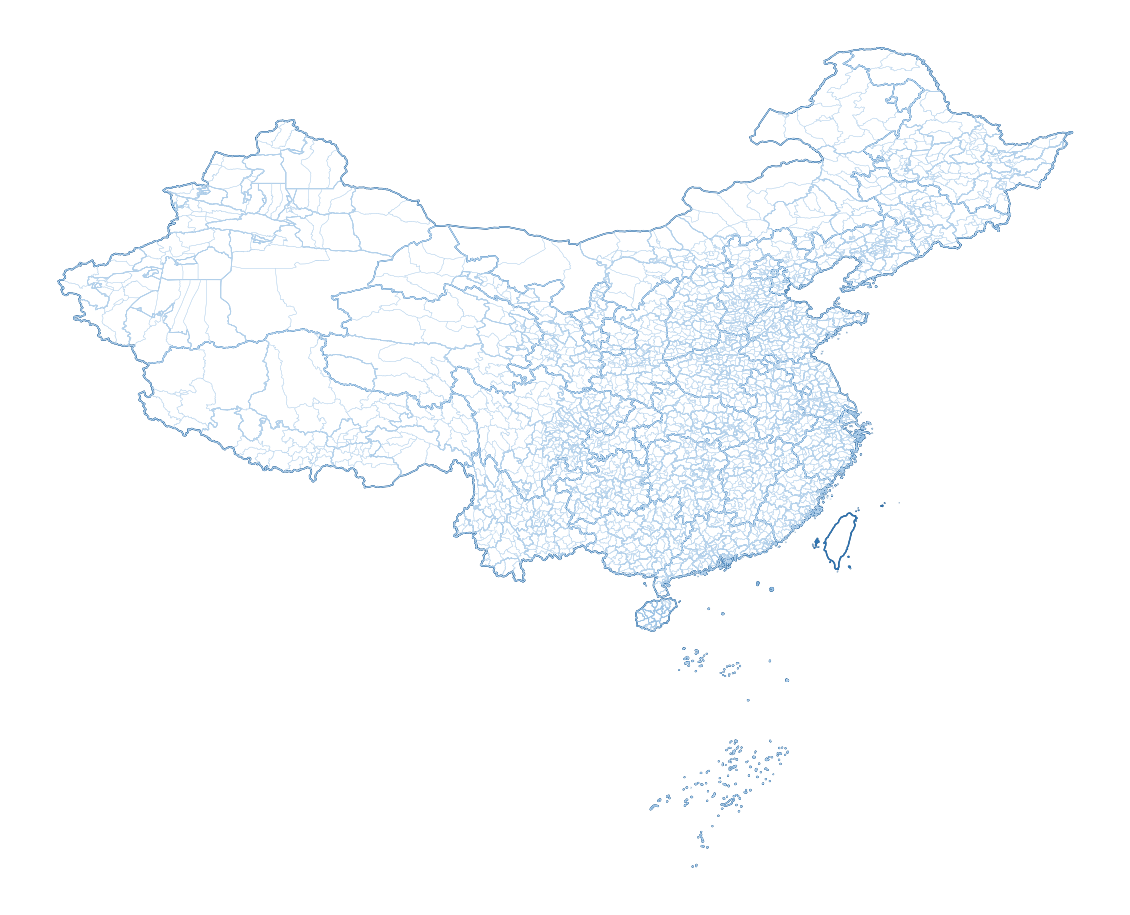

In [39]:
# 绘制边界图
def colors(R,G,B): return "#%02X%02X%02X" % (R,G,B)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,20))
gdf[gdf.level=='country'].plot(ax=ax, color='',edgecolor=colors(30,78,121),linewidth=1.5)
gdf[gdf.level=='province'].plot(ax=ax, color='', edgecolor=colors(46,117,181),linewidth=1.2)
gdf[gdf.level=='city'].plot(ax=ax,color='',edgecolor=colors(156,195,229),linewidth=0.8)
gdf[gdf.level=='district'].plot(ax=ax,color='',edgecolor=colors(189,215,238),linewidth=0.4)
plt.axis('off')
plt.savefig(dpi=600,fname='./district_borders.png')